In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from datetime import datetime

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, roc_auc_score, make_scorer, recall_score

In [98]:
modelos = [
    {
        "nombre": "Naive Bayes",
        "modelo": MultinomialNB(),
        "param_grid": {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            "fit_prior": [True, False],
        },
    },
    {
        "nombre": "Arbol Clasificacion",
        "modelo": DecisionTreeClassifier(),
        "param_grid": {
            "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
            "max_leaf_nodes": [10, 50, 100],
            "criterion": ["gini", "entropy"],
        },
    },
    {
        "nombre": "Random Forest",
        "modelo": RandomForestClassifier(),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "n_estimators": [500, 600, 700, 800, 900, 1000],
        },
    },
    {
        "nombre": "Gradient Bossting",
        "modelo": GradientBoostingClassifier(),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "learning_rate": [0.001, 0.01, 0.1, 1],
        },
    },
    {
        "nombre": "SVM",
        "modelo": SVC(),
        "param_grid": {"C": [0.1, 1, 10, 100], "kernel": ["linear", "poly"], "degree": [2, 3, 4]},
    },
]

In [99]:
def entrenar_ensamble_de_modelos_gridcv(
    grilla_gridcv_con_modelos, X_train, X_test, y_train, y_test
):
    for model_info in grilla_gridcv_con_modelos:
        print("Training", model_info["nombre"], "...")
        model = model_info["modelo"]
        param_grid = model_info["param_grid"]

        grid_search = GridSearchCV(model, param_grid, cv=5, verbose=5)
        grid_search.fit(X_train, y_train)

        obtener_desempeno_modelo_en_grilla(grid_search, X_test, y_test)

def resumir_resultados_grid_cv(diccionario_resultados):
    df_resultados = pd.DataFrame(diccionario_resultados)
    df_resultados["params_str"] = df_resultados["params"].astype(str)

    return df_resultados


def graficar_resultados_grid_cv(resultado_df):
    sns.lineplot(data=resultado_df, x="params_str", y="mean_test_score", marker="o")
    plt.tick_params(axis="x", labelrotation=90)


def analizar_resultados_grid_cv(diccionario_resultados):
    df_resultados = resumir_resultados_grid_cv(diccionario_resultados)
    graficar_resultados_grid_cv(df_resultados)

    return df_resultados


def obtener_desempeno_modelo_en_grilla(modelo_grilla, X_test, y_test):
    print("--------------Resultados Conjunto de Entrenamiento-----------------")
    print("Los resultados en la busqueda de hiperparametros son:")
    resultados_grilla = analizar_resultados_grid_cv(modelo_grilla.cv_results_)
    plt.show()
    print(f"Los mejores parametros fueron: {modelo_grilla.best_params_}")
    print(f"El mejor desempeno fue: {modelo_grilla.best_score_}")

    print("\n\n--------------Resultados Conjunto de Validacion-----------------")
    yhat = modelo_grilla.predict(X_test)
    print("Los resultados en el conjunto de validacion son:")
    print(classification_report(y_test, yhat))

    print("---------------------------------------------------------------------")

    return resultados_grilla

In [100]:
df = pd.read_csv("RegistroTumores_FALP.csv")

In [108]:
# Deja solo el cancer de mama
mama = df.query("CATEGORIA == 'MAMA'")
mama = mama.drop(columns=["CATEGORIA", "SUBCATEGORIA", "CODIGO_COMUNA", "ID_CASO"])
# Elimina los que carezcan de un estadio
mama = mama[~mama["ESTADIO"].isna()]
# Binariza la edad
mama["RANGO_ETARIO"] = pd.cut(
    mama["EDAD"],
    [-np.inf, 5, 11, 18, 26, 60, np.inf],
    labels=["Primera Infancia", "Infancia", "Adolescencia", "Juventud", "Adultez", "Vejez"],
)
mama = mama.drop(columns=["EDAD"])

# Solamente deja las filas que tengan al menos 1 examen
columnas_a_rellenar_nan = ["CT", "CN", "CM", "PT", "PN", "PM"]
mama = mama.dropna(subset=columnas_a_rellenar_nan, how="all")

# Castea las fechas
columnas_fechas = ["FECHA_DIAGNOSTICO", "FECHA_DEFUNCION", "FECHA_INICIO_TTO", "FECHA_FIN_TTO"]
for fecha in columnas_fechas:
    mama[fecha] = pd.to_datetime(mama[fecha], yearfirst=True)
    pd.to_datetime(mama[fecha], yearfirst=True)

mama["DIAS_TTO"] = (mama["FECHA_FIN_TTO"] - mama["FECHA_INICIO_TTO"]).dt.days
mama["ESPERA_TRATAMIENTO"] = (mama["FECHA_INICIO_TTO"] - mama["FECHA_DIAGNOSTICO"]).dt.days
mama["PROYECCION_DIAS"] = (mama["FECHA_DEFUNCION"] - mama["FECHA_DIAGNOSTICO"]).dt.days

columnas_fechas_calculadas = ["DIAS_TTO", "ESPERA_TRATAMIENTO", "PROYECCION_DIAS"]

mama = mama.drop(columns=columnas_fechas)
mama[columnas_fechas_calculadas] = mama[columnas_fechas_calculadas].fillna(0)

# Crea el vector objetivo
reemplazar_estadio = {
    "0": 1,
    "I": 1,
    "II": 2,
    "III": 3,
    "IV": 3,
}

mama["STATUS"] = mama["ESTADIO"].replace(reemplazar_estadio)
mama = mama.drop(columns=["ESTADIO"])

columnas_faltantes = [
    "CONVENIO_ONCOLOGICO",
    "CT",
    "CN",
    "CM",
    "PT",
    "PN",
    "PM",
    "EXTENSION_DIAGNOSTICO",
    "TTO_FALP_SUBCATEGORIA",
]

mama[columnas_faltantes] = mama[columnas_faltantes].fillna("SO")

In [110]:
final = pd.get_dummies(mama, drop_first=True)
X = final.drop(columns="STATUS")
y = final["STATUS"]

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=1)

In [112]:
entrenar_ensamble_de_modelos_gridcv(modelos, X_train, X_test, y_train, y_test)

Training Naive Bayes ...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........alpha=0.0001, fit_prior=True;, score=nan total time=   0.0s
[CV 2/5] END ........alpha=0.0001, fit_prior=True;, score=nan total time=   0.0s
[CV 3/5] END ........alpha=0.0001, fit_prior=True;, score=nan total time=   0.0s
[CV 4/5] END ........alpha=0.0001, fit_prior=True;, score=nan total time=   0.0s
[CV 5/5] END ........alpha=0.0001, fit_prior=True;, score=nan total time=   0.0s
[CV 1/5] END .......alpha=0.0001, fit_prior=False;, score=nan total time=   0.0s
[CV 2/5] END .......alpha=0.0001, fit_prior=False;, score=nan total time=   0.0s
[CV 3/5] END .......alpha=0.0001, fit_prior=False;, score=nan total time=   0.0s
[CV 4/5] END .......alpha=0.0001, fit_prior=False;, score=nan total time=   0.0s
[CV 5/5] END .......alpha=0.0001, fit_prior=False;, score=nan total time=   0.0s
[CV 1/5] END .........alpha=0.001, fit_prior=True;, score=nan total time=   0.0s
[CV 2/5] END .........a

ValueError: 
All the 80 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ppizarro\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ppizarro\AppData\Local\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "c:\Users\ppizarro\AppData\Local\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 898, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "c:\Users\ppizarro\AppData\Local\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1418, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


# Modelos solamente con variables patologicas y clinicas

In [67]:
solo_patologicas = mama[columnas_a_rellenar_nan + ["STATUS"]]
final = pd.get_dummies(solo_patologicas, drop_first=True)
X = final.drop(columns="STATUS")
y = final["STATUS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=1)

Training Naive Bayes ...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ......alpha=0.0001, fit_prior=True;, score=0.784 total time=   0.0s
[CV 2/5] END ......alpha=0.0001, fit_prior=True;, score=0.831 total time=   0.0s
[CV 3/5] END ......alpha=0.0001, fit_prior=True;, score=0.819 total time=   0.0s
[CV 4/5] END ......alpha=0.0001, fit_prior=True;, score=0.833 total time=   0.0s
[CV 5/5] END ......alpha=0.0001, fit_prior=True;, score=0.836 total time=   0.0s
[CV 1/5] END .....alpha=0.0001, fit_prior=False;, score=0.800 total time=   0.0s
[CV 2/5] END .....alpha=0.0001, fit_prior=False;, score=0.847 total time=   0.0s
[CV 3/5] END .....alpha=0.0001, fit_prior=False;, score=0.831 total time=   0.0s
[CV 4/5] END .....alpha=0.0001, fit_prior=False;, score=0.834 total time=   0.0s
[CV 5/5] END .....alpha=0.0001, fit_prior=False;, score=0.841 total time=   0.0s
[CV 1/5] END .......alpha=0.001, fit_prior=True;, score=0.784 total time=   0.0s
[CV 2/5] END .......alp

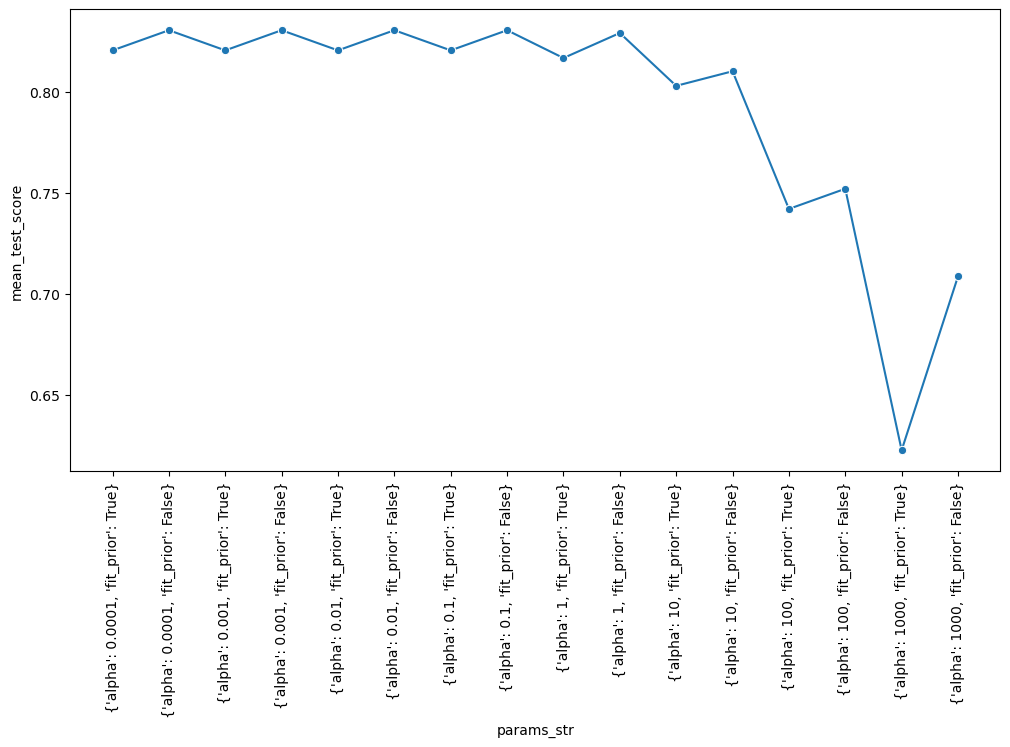

Los mejores parametros fueron: {'alpha': 0.0001, 'fit_prior': False}
El mejor desempeno fue: 0.8306896551724139


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.92      0.87      0.90       471
           2       0.86      0.79      0.82       563
           3       0.76      0.89      0.82       414

    accuracy                           0.84      1448
   macro avg       0.85      0.85      0.84      1448
weighted avg       0.85      0.84      0.84      1448

---------------------------------------------------------------------
Training Arbol Clasificacion ...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END criterion=gini, max_depth=3, max_leaf_nodes=10;, score=0.707 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=3, max_leaf_nodes=10;, score=0.743 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=3

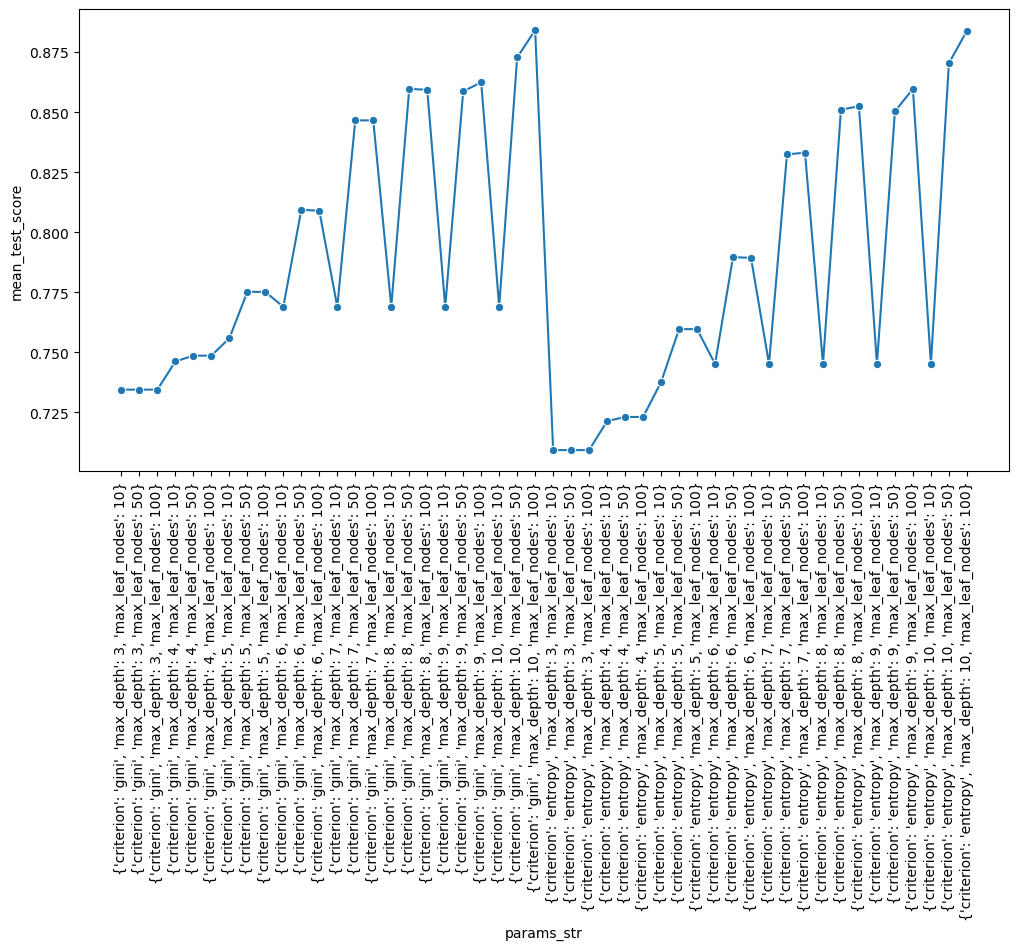

Los mejores parametros fueron: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 100}
El mejor desempeno fue: 0.8841379310344827


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.99      0.87      0.92       471
           2       0.91      0.89      0.90       563
           3       0.81      0.95      0.88       414

    accuracy                           0.90      1448
   macro avg       0.90      0.90      0.90      1448
weighted avg       0.91      0.90      0.90      1448

---------------------------------------------------------------------
Training Random Forest ...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5] END max_depth=5, max_leaf_nodes=10, min_samples_split=2, n_estimators=500;, score=0.755 total time=   0.6s
[CV 2/5] END max_depth=5, max_leaf_nodes=10, min_samples_split=2, n_estimators=500;, score

KeyboardInterrupt: 

In [68]:
entrenar_ensamble_de_modelos_gridcv(modelos, X_train, X_test, y_train, y_test)